In [1]:
import fileinput
from typing import List
from torch import tensor, FloatTensor
import torch

aspects: List[float] = []

# https://huggingface.co/datasets/Birchlabs/danbooru-aspect-ratios/resolve/main/danbooru-aspect-ratios.csv
with fileinput.input(files=('/home/birch/ml-data/danbooru-aspect-ratios.csv'), encoding='ascii') as f:
  # skip header line
  next(f)
  for line in f:
    aspect = float(line.rstrip('\n'))
    aspects.append(aspect)

device = torch.device('cuda')

a: FloatTensor = tensor(aspects, dtype=torch.float32, device=device)

used 48 iterations (0.6401s) to cluster 6378288 items into 20 clusters
top 20 angles (º):
tensor([ 9.4641, 18.9653, 25.0724, 28.6335, 30.5324, 32.0958, 33.4521, 34.3734,
        35.2827, 35.9798, 36.8721, 37.8479, 38.9281, 40.5593, 42.6563, 45.1799,
        49.0873, 52.7660, 55.6326, 61.7815], device='cuda:0')
top 20 aspect ratios:
tensor([0.1667, 0.3437, 0.4678, 0.5460, 0.5898, 0.6272, 0.6607, 0.6840, 0.7076,
        0.7260, 0.7501, 0.7770, 0.8077, 0.8559, 0.9214, 1.0063, 1.1539, 1.3158,
        1.4622, 1.8635], device='cuda:0')


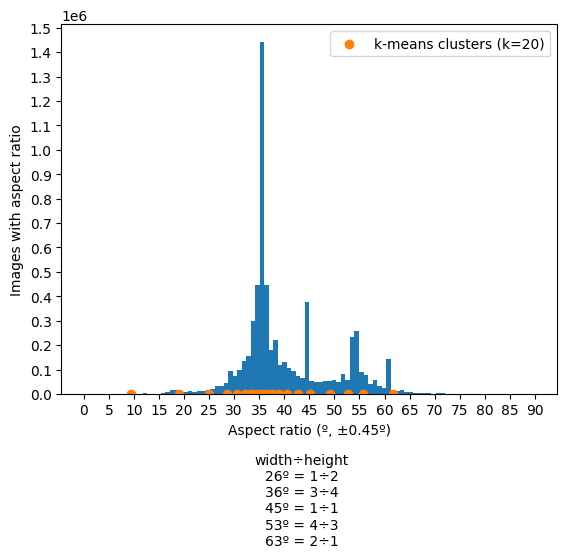

In [135]:
from kmeans_pytorch import kmeans
from fast_pytorch_kmeans import KMeans
from torch import randn, Generator, histc, linspace, zeros_like
import matplotlib.pyplot as plt
import math

gen = Generator(device=device).manual_seed(1234)
# samp: FloatTensor = randn(100, dtype=torch.float32, device=device, generator=gen)
# samp = a#[:1000]
samp = (180/math.pi*a.atan())

bin_min, bin_max = samp.min(), samp.max()
bin_count = 100
bin_occupants: FloatTensor = histc(samp, bins = bin_count)
bins: FloatTensor = linspace(start=bin_min, end=bin_max, steps=bin_count, device=device)
bin_step: FloatTensor = (bin_max-bin_min)/(bin_count-1)
bin_half_step: FloatTensor = bin_step / 2
bin_mids: FloatTensor = bins + bin_half_step

n_clusters = 20
# cluster_ids_x, cluster_centers = kmeans(
#   X=samp.unsqueeze(-1), num_clusters=n_clusters, distance='euclidean', device=device
# )
kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=1, max_iter=5000)
kmeans.fit_predict(samp.unsqueeze(-1))
cluster_centers: FloatTensor = kmeans.centroids

plt.bar(x=bins.cpu(), height=bin_occupants.cpu(), width=bin_step.cpu())
plt.scatter(cluster_centers.cpu(), zeros_like(cluster_centers, device='cpu'), label=f'k-means clusters (k={n_clusters})')
plt.legend()
plt.xlabel(f'Aspect ratio (º, ±{bin_half_step.item():.2f}º)')
plt.locator_params(nbins=20)
plt.ylabel('Images with aspect ratio')
expl = '''width÷height
26º = 1÷2
36º = 3÷4
45º = 1÷1
53º = 4÷3
63º = 2÷1'''
plt.figtext(0.5, -0.2, expl, wrap=True, horizontalalignment='center', fontsize=10)
cluster_centers, _ = cluster_centers.squeeze().sort()
clusters_radians: FloatTensor = math.pi/180*cluster_centers
clusters_ratios: FloatTensor = clusters_radians.tan()

print(f'top 20 angles (º):\n{cluster_centers}')
print(f'top 20 aspect ratios:\n{clusters_ratios}')

In [140]:
from torch import IntTensor

for side_len in (512,):#, 1024):
  thetas_sin: FloatTensor = clusters_radians.sin()
  thetas_cos: FloatTensor = clusters_radians.cos()

  hypotenuses: FloatTensor = side_len/(2*thetas_sin*thetas_cos)**.5

  heights: FloatTensor = hypotenuses*2**.5*thetas_sin
  widths: FloatTensor = hypotenuses*2**.5*thetas_cos

  buckets = torch.column_stack([heights, widths])
  buckets_rounded: IntTensor = 8*(buckets / 8).round().int()

  print(f'bucket sizes with area approx {side_len}*{side_len} (height*width):\n{buckets_rounded}')

bucket sizes with area approx 512*512 (height*width):
tensor([[ 208, 1256],
        [ 304,  872],
        [ 352,  752],
        [ 376,  696],
        [ 392,  664],
        [ 408,  648],
        [ 416,  632],
        [ 424,  616],
        [ 432,  608],
        [ 440,  600],
        [ 440,  592],
        [ 448,  584],
        [ 464,  568],
        [ 472,  552],
        [ 488,  536],
        [ 512,  512],
        [ 552,  480],
        [ 584,  448],
        [ 616,  424],
        [ 696,  376]], device='cuda:0', dtype=torch.int32)
